In [1]:
import sys
import os
sys.path.insert(0, f"/home/txm/gpu_txmdata/integration/package/v1.0/scMIAC/")

In [2]:
import anndata as ad
import scanpy as sc

from scmiac.scmiac import find_anchors,preprocess,train_model,model_inference
from scmiac.preprocess import run_umap

In [3]:
adata_rna_file = f"/home/txm/gpu_txmdata/integration/scMIAAC_v0/01_experiments/01_cell_level/10x/data/adata_rna_10x.h5ad"
adata_atac_file = f"/home/txm/gpu_txmdata/integration/scMIAAC_v0/01_experiments/01_cell_level/10x/data/adata_atac_10x.h5ad"

In [4]:
adata_rna = sc.read(adata_rna_file)
print(adata_rna)
adata_atac = sc.read(adata_atac_file)
print(adata_atac)

AnnData object with n_obs × n_vars = 10412 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell_type', 'cell_type_merge', 'cell_type_merge_rna', 'cell_type_rna', 'modality', 'is_anchor_rna'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_umap', 'cca', 'pt_vae_latent', 'pt_vae_latent_umap', 'scmiaac_latent'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
AnnData object with n_obs × n_vars = 10412 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell_type', 'kendall_pred', 'max_cor', 'diff', 'true', 'kendall_pred_booltrue', 'GMSS', 'NMSS', 'is_seed', 'seed', 'wknn_pred', 'wknn_pred_prob', 'grasp_pred', 'grasp_pred_prob', 'atacannor_pred', 'pred', 'cell_type_merge', 'cell_type_merge_atac', 'cell_type_atac', 'modality', 'is_anchor_atac'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions

In [ ]:
anchor_df = find_anchors(
    adata_rna,
    adata_atac
)

Number of common genes: 18353
Find anchors across datasets.
1. prepare input matrix for CCA
2. run cca between datasets
Run CCA
non zero dims 30
3. normalize CCV per sample/row
4. find MNN of U and V to find anchors
Find Anchors using k=30
5. filter anchors by high dimensional neighbors
6. score anchors with snn and local structure preservation
Number of anchor pairs: 18298
Number of anchors pairs after cell type filtering: 15642
Number of RNA anchors: 6982; Number of ATAC anchors: 6648


In [6]:
rna_vae, atac_vae, all_cells_loader, anchor_cells_loader = preprocess(
    adata_rna, 
    adata_atac,
    anchor_df,
    rna_latent_key = "X_pca",
    atac_latent_key = "lsi49",
    device = 'cuda:0')

In [ ]:
rna_vae, atac_vae = train_model(
    rna_vae, 
    atac_vae, 
    all_cells_loader, 
    anchor_cells_loader, 
    device = "cuda:0", 
    num_epoches = 1000,
    print_step = 100)

Epoch 0, Total: 3323.29, RNA Reco: 1009.58, RNA KLD: 0.28, ATAC Reco: 987.04, ATAC KLD: 0.34, Contra: 1326.05


In [ ]:
rna_embeddings, atac_embeddings = model_inference(
    rna_vae, 
    atac_vae, 
    all_cells_loader)

In [ ]:
adata_rna.obsm['scmiac_latent'] = rna_embeddings
adata_atac.obsm['scmiac_latent'] = atac_embeddings

In [ ]:
adata_cm = ad.concat([adata_rna, adata_atac],join='outer')

/home/txm/miniforge3/envs/scMIAAC/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/txm/miniforge3/envs/scMIAAC/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
adata_cm = run_umap(adata_cm,'scmiac_latent')

UMAP embedding is stored in adata.obsm['scmiac_latent_umap']


/home/txm/miniforge3/envs/scMIAAC/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/txm/miniforge3/envs/scMIAAC/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


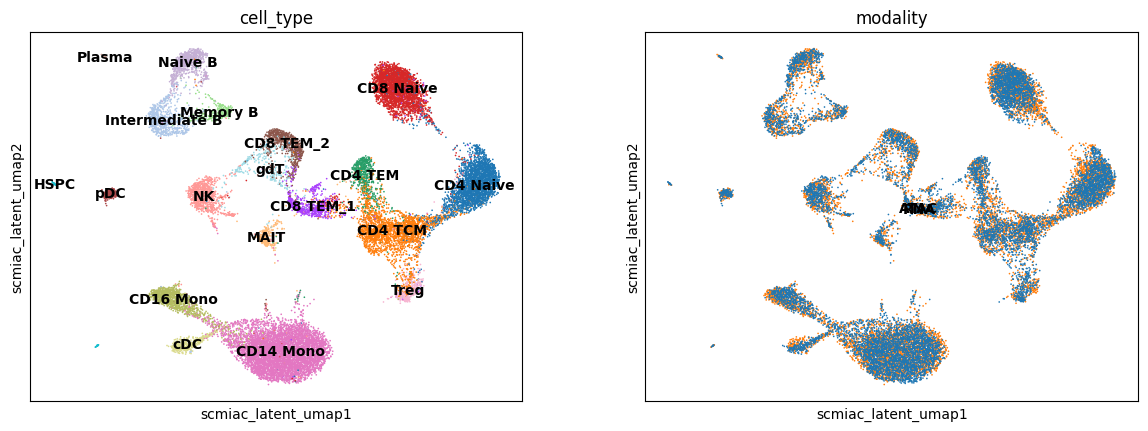

In [ ]:
sc.pl.embedding(adata_cm, basis='scmiac_latent_umap', color=['cell_type','modality'],legend_loc = 'on data')